In [41]:
import sys
sys.path.append('..')

from src.pdfs_numba_stats import SignalBackgroundModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL
from sweights import SWeight

plt.style.use('mystyle.mplstyle')
np.random.seed(42)

- Common to *discriminate* between peaking signal and smooth background in some dimension
    - the <font color="blue">discriminant variable(s)</font>
    
- But often want to understand the properties of the signal in some other dimension
    - the <font color="blue">control variable(s)</font>

## Trial sample size of 10000 

In [42]:
# Parameters
signal_params = {
    'mu': 3, 
    'sigma': 0.3, 
    'beta': 1, 
    'm': 1.4, 
    'decay_rate': 0.3
}
background_params = {
    'mu_bg': 0, 
    'sigma_bg': 2.5
}
f = 0.6  # Signal fraction
x_min, x_max = 0, 5
y_min, y_max = 0, 10

# Create model
model = SignalBackgroundModel(*signal_params.values(), *background_params.values(), f, x_min, x_max, y_min, y_max)

In [43]:
f_max = model.pdf(3, 0)
def accept_reject_sampling_2d_with_Poisson(
        pdf, 
        n_samples: int, 
        x_min: float, x_max: float, 
        y_min: float, y_max: float, 
        f_max: float, 
        random_state: np.random.RandomState = np.random.RandomState(42)
    ):
    # Possion variable on the sample size
    n_samples = np.random.poisson(n_samples)
    # Preallocate space for samples
    samples = np.zeros((n_samples, 2))
    count = 0  # Track the number of accepted samples

    # Generate samples in batches
    batch_size = int(2 * n_samples)  # Choose an appropriate batch size
    while count < n_samples:
        # Generate a batch of candidate points
        x = np.random.uniform(low=x_min, high=x_max, size=batch_size)
        y = np.random.uniform(low=y_min, high=y_max, size=batch_size)
        u = np.random.uniform(low=0, high=f_max, size=batch_size)

        # Evaluate the PDF
        pdf_values = pdf(x, y)

        # Accept samples
        accepted = u < pdf_values
        n_accepted = np.sum(accepted)

        # Limit the number of accepted samples to the remaining capacity
        remaining_capacity = n_samples - count
        n_to_add = min(n_accepted, remaining_capacity)

        # Add only as many samples as fit in the remaining capacity
        samples[count:count + n_to_add] = np.column_stack((x[accepted], y[accepted]))[:n_to_add]
        count += n_to_add

    return samples[:n_samples]


### Fit data to get distributions in X dimension and N and f


In [44]:
model = SignalBackgroundModel(*signal_params.values(), *background_params.values(), f, x_min, x_max, y_min, y_max)
trial_data = accept_reject_sampling_2d_with_Poisson(model.pdf, 10000, x_min, x_max, y_min, y_max, f_max)

 # discriminant variable: X
def p_s_x(x, mu, sigma, beta, m):
    return model.s_pdf_x(mu, sigma, beta, m, x, 0, 5)
def p_b_x(x):
    return model.b_pdf_x(x, 0, 5)

def p_tot(x, N, f, mu, sigma, beta, m, comps=['S', 'B']):
    res = np.zeros_like(x)
    if 'S' in comps:
        res = res + N * f * p_s_x(x, mu, sigma, beta, m)
    if 'B' in comps:
        res = res + N * (1 - f) * p_b_x(x)
    return res
def p_tot_extended(x, N, f, mu, sigma, beta, m):
    return N, p_tot(x, N, f, mu, sigma, beta, m)

x_samples = trial_data.T[0, :]
y_samples = trial_data.T[1, :]
n2ll = ExtendedUnbinnedNLL(data=x_samples, scaled_pdf=p_tot_extended)
mi_sw = Minuit(n2ll, N=1000, f=0.6, mu=3, sigma=0.3, beta=1, m=1.4)
mi_sw.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1.369e+05                 │              Nfcn = 360              │
│ EDM = 3.86e-05 (Goal: 0.0002)    │            time = 0.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  9.96e3   │  0.10e3   │            │            │         │         │       │
│ 1 │ f     │   0.608   │   0.012   │            │            │         │         │       │
│ 2 │ mu    │   2.993   │   0.008   │            │            │         │         │       │
│ 3 │ sigma │   0.300   │   0.008   │            │            │         │         │       │
│ 4 │ beta  │   1.08    │   0.08    │            │            │         │         │       │
│ 5 │ m     │   1.13    │   0.18    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │         N         f        mu     sigma      beta         m │
├───────┼─────────────────────────────────────────────────────────────┤
│     N │  9.16e+03  23.01e-3  37.00e-3 -16.33e-3    -0.654     0.982 │
│     f │  23.01e-3  0.000157  -0.01e-3   0.04e-3   0.22e-3  -1.10e-3 │
│    mu │  37.00e-3  -0.01e-3  6.53e-05  -0.04e-3  -0.33e-3   0.56e-3 │
│ sigma │ -16.33e-3   0.04e-3  -0.04e-3  6.74e-05   0.34e-3  -0.67e-3 │
│  beta │    -0.654   0.22e-3  -0.33e-3   0.34e-3   0.00629    -0.013 │
│     m │     0.982  -1.10e-3   0.56e-3  -0.67e-3    -0.013    0.0333 │
└───────┴─────────────────────────────────────────────────────────────┘

In [45]:
sf = lambda x: p_s_x(x, 
            mi_sw.values['mu'], mi_sw.values['sigma'], mi_sw.values['beta'], mi_sw.values['m'])
bf = lambda x: p_b_x(x)
sy = mi_sw.values['N'] * mi_sw.values['f']
by = mi_sw.values['N'] * (1 - mi_sw.values['f'])

xrange = [0, 5]
yrange = [0, 10]
sweighter = SWeight(x_samples, pdfs=[sf, bf], yields=[sy, by], discvarranges=(xrange,))

    PDF normalisations:
	 0 0.9999999997000573
	 1 1.0
    Integral of w*pdf matrix (should be close to the
                identity):
	[[9.99417305e-01 8.55551032e-04]
	 [5.60345123e-04 9.99133434e-01]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  6058.5421 |  6058.5421 |    -0.00% |
	  1        |  3905.2795 |  3905.2795 |     0.00% |


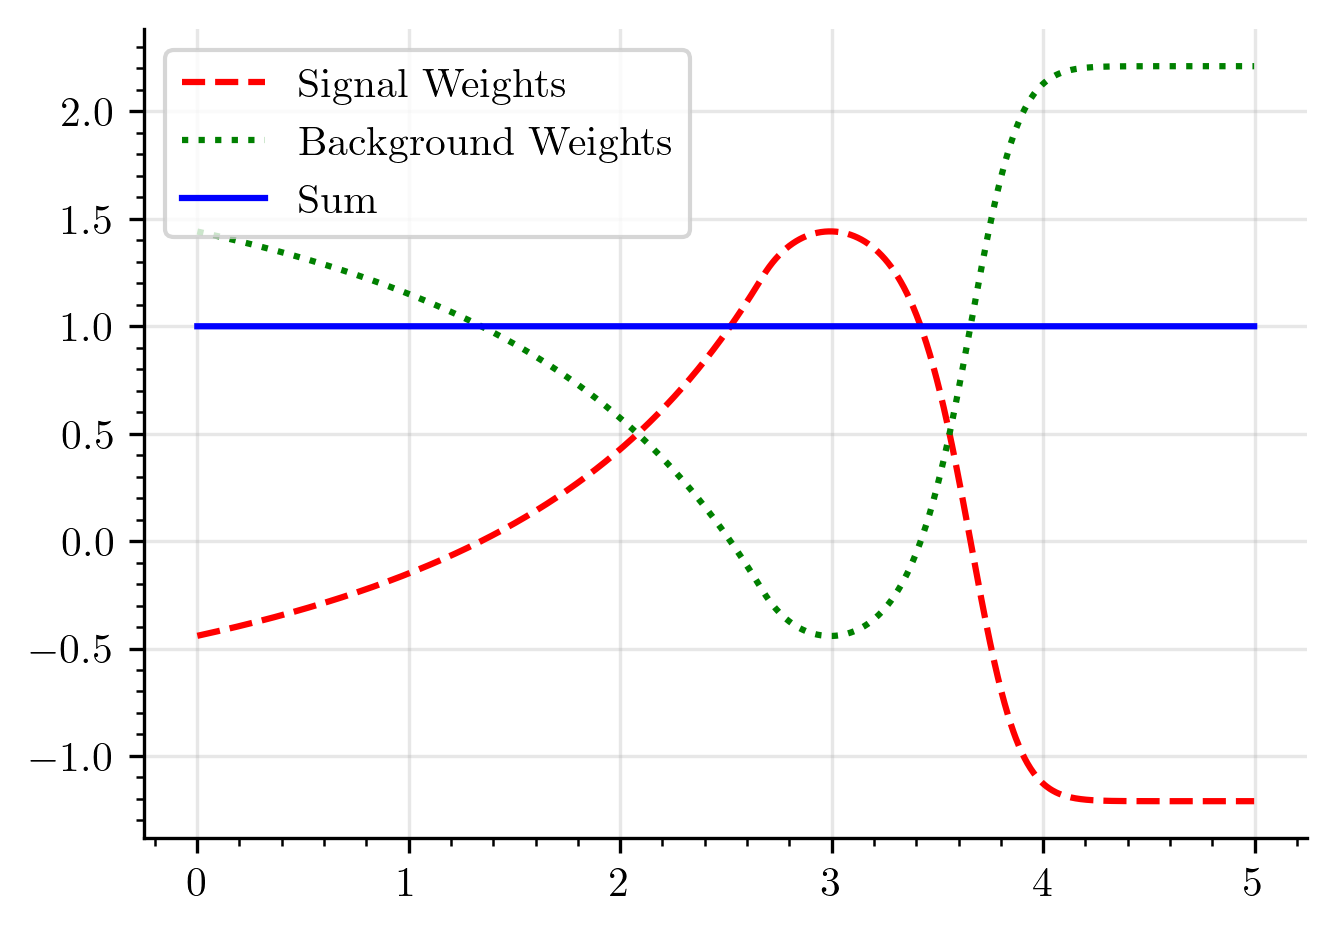

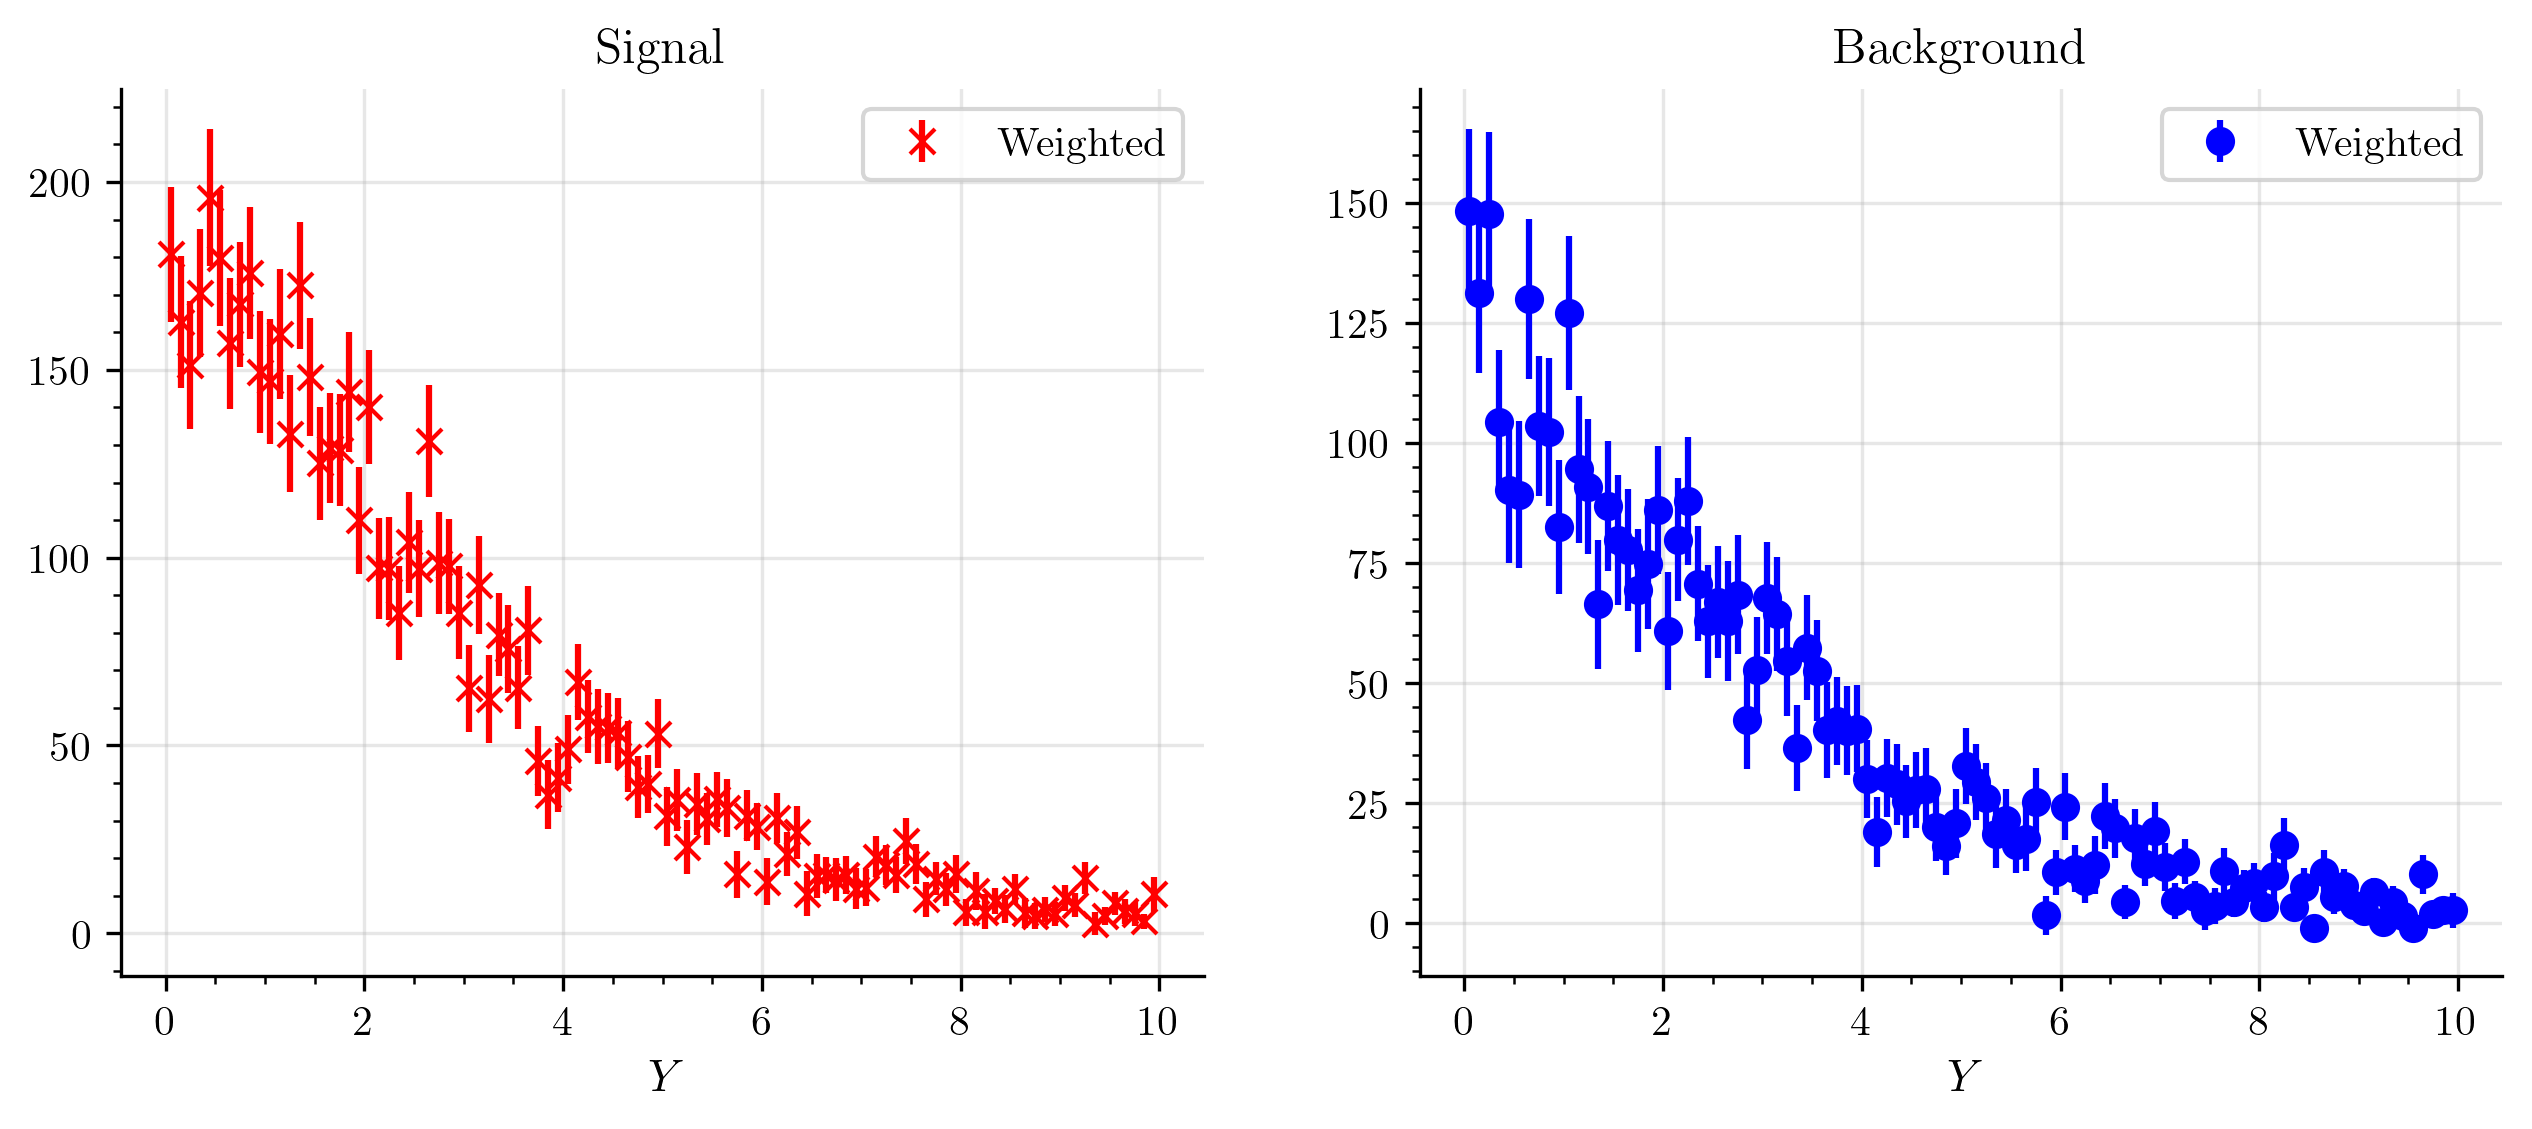

In [46]:
sw = sweighter.get_weight(0, np.sort(x_samples))
bw = sweighter.get_weight(1, np.sort(x_samples))

plt.figure()
plt.plot(np.sort(x_samples), sw, 'r--', label='Signal Weights')
plt.plot(np.sort(x_samples), bw, 'g:', label='Background Weights')
plt.plot(np.sort(x_samples), sw+bw, 'b-', label='Sum')
plt.legend()
plt.savefig('../report/images/weights.pdf', bbox_inches='tight')
plt.show()

ysw, ye = np.histogram( y_samples, bins=100, range=yrange, weights=sw )
ybw, ye = np.histogram( y_samples, bins=100, range=yrange, weights=bw )

ysw2, ye = np.histogram( y_samples, bins=100, range=yrange, weights=sw**2 )
ybw2, ye = np.histogram( y_samples, bins=100, range=yrange, weights=bw**2 )

cy = 0.5*(ye[1:]+ye[:-1])

fig, ax = plt.subplots(1, 2, figsize=(0.8*12.8, 0.8*4.8))

ax[0].errorbar( cy, ysw, ysw2**0.5, fmt='rx', label='Weighted' )
ax[0].legend()
ax[0].set_title('Signal')
ax[1].errorbar( cy, ybw, ybw2**0.5, fmt='bo', label='Weighted' )
ax[1].legend()
ax[1].set_title('Background')

ax[0].set_xlabel('$Y$')
ax[1].set_xlabel('$Y$')
plt.savefig('../report/images/weighted_histograms.pdf', bbox_inches='tight')

### Fitting the weighted data

In [47]:
def signal_pdf(y, decay_rate):
    return decay_rate * np.exp(-decay_rate * y)

def weighted_nll(decay_rate, y_samples, weights):
    pdf_vals = signal_pdf(y_samples, decay_rate)
    return -np.sum(weights * np.log(pdf_vals))

# unbinned fit
mi_swy = Minuit(lambda decay_rate: weighted_nll(decay_rate, y_samples, bw), 
            decay_rate=0.3) 
mi_swy.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7450                       │              Nfcn = 19               │
│ EDM = 3.96e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name       │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ decay_rate │   0.403   │   0.009   │            │            │         │         │       │
└───┴────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────────┬────────────┐
│            │ decay_rate │
├────────────┼────────────┤
│ decay_rate │   8.34e-05 │
└────────────┴────────────┘

## Change Sample Size

In [48]:
# Read the same data in bootstrapping (all_samples.npy)
all_samples = np.load('all_samples.npy', allow_pickle=True)
all_samples = all_samples.item()

In [49]:
sample_sizes = [500, 1000, 2500, 5000, 10000]
results = {
    'sample_size': [],
    'estimate': [],
    'uncertainty': [],
    'truth': []
}
for sample_size in sample_sizes:
    samples = all_samples[sample_size]
    # Fit the model to the data to get distributions in X dimension and N and f
    x_samples = samples.T[0, :]
    y_samples = samples.T[1, :]
    n2ll = ExtendedUnbinnedNLL(data=x_samples, scaled_pdf=p_tot_extended)
    mi_sw = Minuit(n2ll, N=sample_size, f=0.6, mu=3, sigma=0.3, beta=1, m=1.4)
    mi_sw.migrad()

    sf = lambda x: p_s_x(x, 
            mi_sw.values['mu'], mi_sw.values['sigma'], mi_sw.values['beta'], mi_sw.values['m'])
    bf = lambda x: p_b_x(x)
    sy = mi_sw.values['N'] * mi_sw.values['f']
    by = mi_sw.values['N'] * (1 - mi_sw.values['f'])

    # Get sWeights
    sweighter = SWeight(x_samples, pdfs=[sf, bf], yields=[sy, by], discvarranges=(xrange,))
    sw = sweighter.get_weight(0, np.sort(x_samples))
    bw = sweighter.get_weight(1, np.sort(x_samples))

    # Get histograms
    ysw, ye = np.histogram( y_samples, bins=100, range=yrange, weights=sw )
    ybw, ye = np.histogram( y_samples, bins=100, range=yrange, weights=bw )
    
    # Fit the weighted data
    mi_swy = Minuit(lambda decay_rate: weighted_nll(decay_rate, y_samples, bw), 
            decay_rate=0.3) 
    mi_swy.migrad()

    results['sample_size'].append(sample_size)
    results['estimate'].append(mi_swy.values['decay_rate'])
    results['uncertainty'].append(mi_swy.errors['decay_rate'])
    results['truth'].append(0.3)


    PDF normalisations:
	 0 1.000000000107395
	 1 1.0
    Integral of w*pdf matrix (should be close to the
                identity):
	[[9.99070035e-01 1.24483019e-03]
	 [9.45194267e-04 9.98893729e-01]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |   293.1687 |   293.1687 |    -0.00% |
	  1        |   200.8636 |   200.8636 |     0.00% |
    PDF normalisations:
	 0 0.999999999736641
	 1 1.0
    Integral of w*pdf matrix (should be close to the
                identity):
	[[0.99783703 0.0015725 ]
	 [0.00157799 0.99835421]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |   530.7517 |   530.7517 |    -0.00% |
	  1        |   439.9054 |   439.9054 |     0.00% |
    PDF normalisations:
	 0 1.0000000000089009
	 1 1.0
    Integral of w*pdf matrix (should be c

In [50]:
results_df = pd.DataFrame(results)
results_df.to_csv('sWeights_results.csv', index=False)
results_df

,sample_size,estimate,uncertainty,truth
0,500,0.374516,0.037371,0.3
1,1000,0.409456,0.027608,0.3
2,2500,0.401050,0.019033,0.3
3,5000,0.383212,0.011413,0.3
4,10000,0.395165,0.008759,0.3


### Visualization

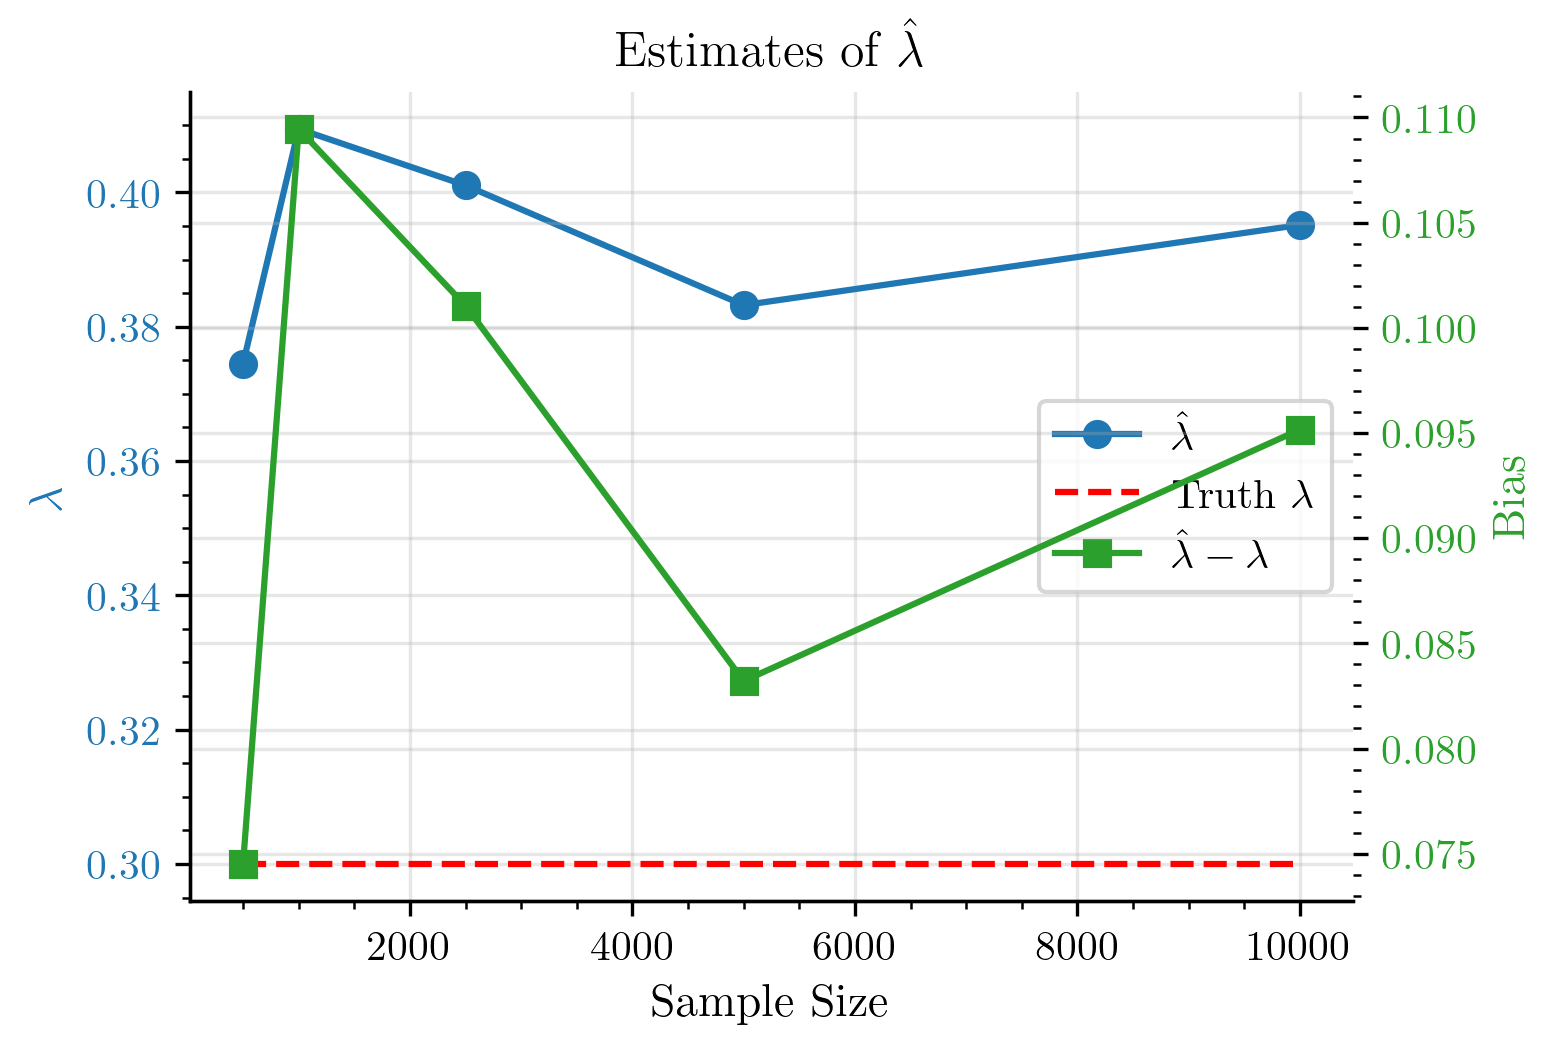

In [51]:
fig, ax1 = plt.subplots()
color1 = 'tab:blue'
ax1.set_xlabel('Sample Size')
ax1.set_ylabel('$\lambda$', color=color1)
ax1.plot(results_df['sample_size'], results_df['estimate'], '-o', color=color1, label='$\hat{\lambda}$')
ax1.plot(results_df['sample_size'], results_df['truth'], color='red', linestyle='--', label='Truth $\lambda$')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()
color2 = 'tab:green'
ax2.set_ylabel('Bias', color=color2)
bias = results_df['estimate'] - results_df['truth']
ax2.plot(results_df['sample_size'], bias, '-s', color=color2, label='$\hat{\lambda}-\lambda$')
ax2.tick_params(axis='y', labelcolor=color2)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Estimates of $\hat{\lambda}$')
plt.savefig('../report/images/sweight_sizes_estimates.pdf', bbox_inches='tight')
plt.show()

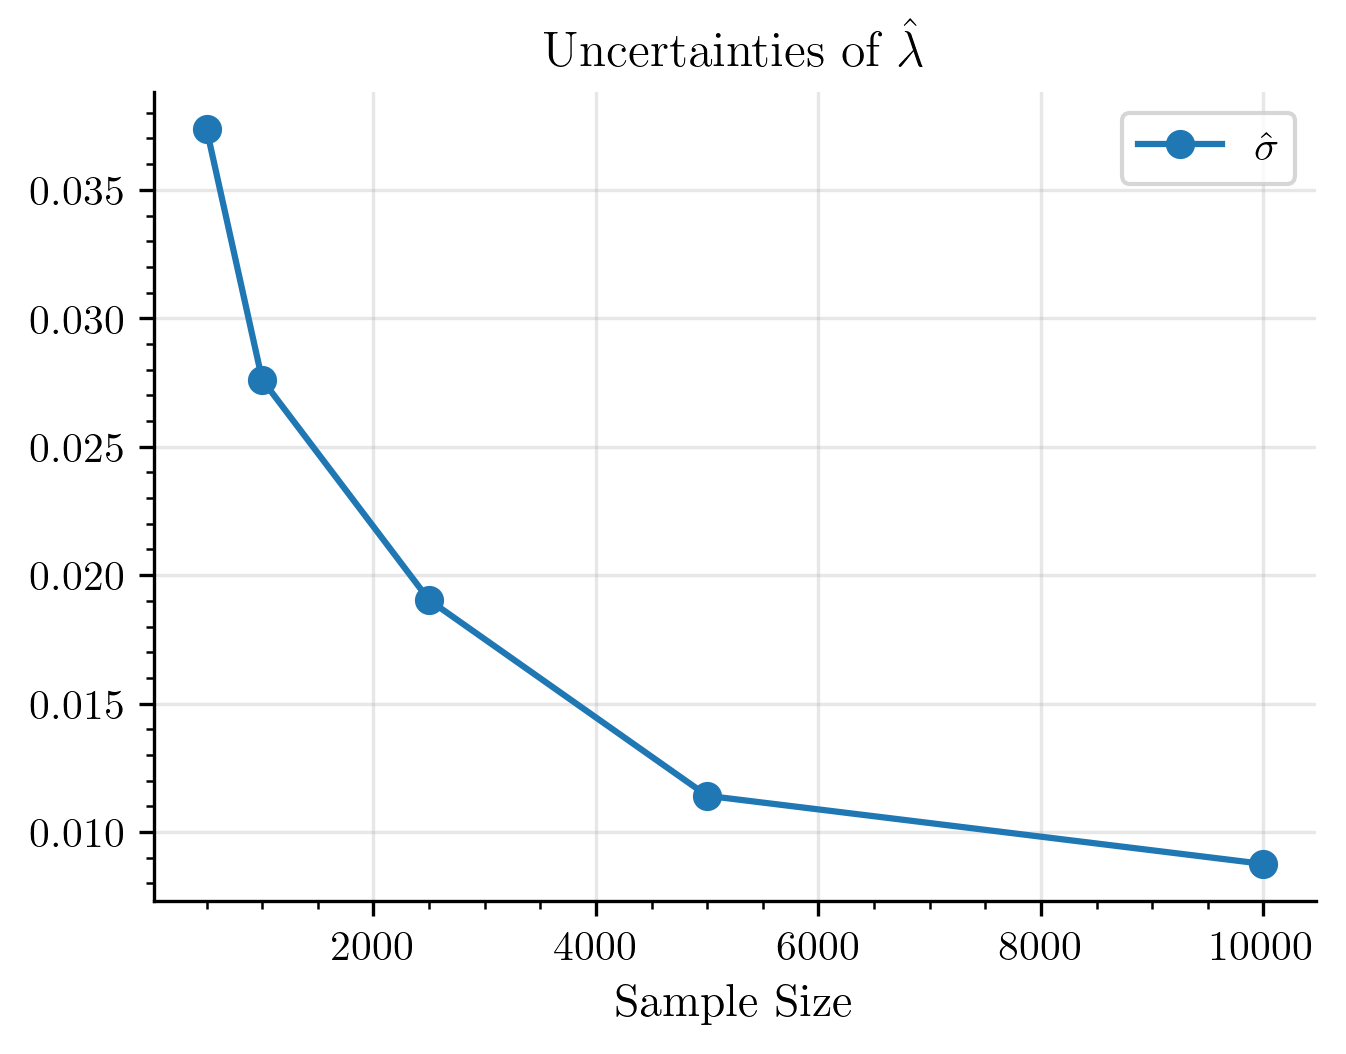

In [52]:
plt.figure()
plt.plot(results_df['sample_size'], results_df['uncertainty'], '-o', label='$\hat{\sigma}$')
plt.xlabel('Sample Size')
plt.title('Uncertainties of $\hat{\lambda}$')
plt.legend()
plt.savefig('../report/images/sweight_sizes_uncertainties.pdf', bbox_inches='tight')
plt.show()